# Cross Validation
Our test=True/False error introduced the problem that it's important whether you use the fit_transform or only the transform function. In the tcrexmodel notebook however, fit_transform was done one the entire dataset and the train and test set where splitted afterwards from each other. In this notebook, I'll take a look at the difference between those two methods (using a random forest classifier).

## Approach 1: Generate features on the entire dataset and split afterwards

In [1]:
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test
import numpy as np

df = get_train_dataset()
# df = df.sample(n=1000)

df_reaction_column = df['reaction']
df_features = get_features(df)

df_features.reset_index(drop=True, inplace=True)
df_reaction_column.reset_index(drop=True, inplace=True)

assert df_features.shape[0] == df_reaction_column.shape[0]
assert np.isnan(df_reaction_column).sum().sum() == 0

In [2]:
# df_features = df_features.fillna(0)  # RandomForestClassifier can't handle NaN values, will be filled later

# add the reaction column to the features (will be dropped later on)
df_features['reaction'] = df_reaction_column

### Single slice

In [3]:
df_train, df_test = train_test_split(df_features, test_size=0.2, random_state=42)

y = df_train['reaction']
x = df_train.drop(['reaction'], axis=1)

y_test = df_test['reaction']
x_test = df_test.drop(['reaction'], axis=1)

assert 'reaction' not in x.columns
assert 'reaction' not in x_test.columns
assert np.isnan(y).sum() == 0
assert np.isnan(y_test).sum() == 0

In [4]:
# replace nan values with 0
x = x.fillna(0)
x_test = x_test.fillna(0)

assert np.isnan(x).sum().sum() == 0
assert np.isnan(x_test).sum().sum() == 0

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(x, y)

RandomForestClassifier(random_state=0)

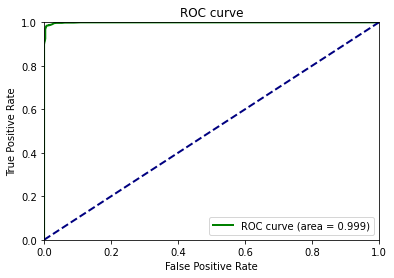

0.9992345693674226

In [6]:
from util import calculate_auc_and_plot

y_pred = clf.predict_proba(x_test)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

### 5-fold cross validation

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')
print(scores)

[0.99868865 0.99872376 0.99898539 0.99775409 0.99827985]


In [8]:
# Get the mean, standard deviation, ...
print(f"ROC: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

ROC: 0.998 (+/- 0.001)


Why standard deviation times two?

The standard deviation is a measure of the spread or variability of a set of data. Multiplying it by two gives you a range that contains roughly 95% of the data. This is because approximately 95% of the data in a normal distribution falls within two standard deviations of the mean, so multiplying the standard deviation by two gives you a range that covers most of the data. (src: https://chat.openai.com/chat "Why do you do standard deviation times two to get the +/- error" and https://stats.stackexchange.com/questions/295459/does-mean-plus-2-times-standard-deviation-always-filter-out-a-fixed-proportion-f )

## Approach 2: Generate features on the train and test set separately

In [9]:
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test, calculate_auc_and_plot
import numpy as np

df = get_train_dataset()
# df = df.sample(n=1000)

### Single slice

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(train)
y = train['reaction']

x_test = get_features(test, test=True)
y_test = test['reaction']

x_test = fix_test(x_test, x.columns)

assert x.columns.equals(x_test.columns)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


In [11]:
# replace nan values with 0
x = x.fillna(0)
x_test = x_test.fillna(0)

assert np.isnan(x).sum().sum() == 0
assert np.isnan(x_test).sum().sum() == 0

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(x, y)

RandomForestClassifier(random_state=0)

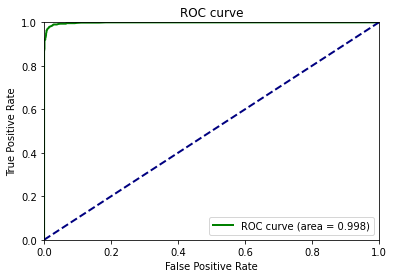

In [13]:
y_pred = clf.predict_proba(x_test)[:, 1]
roc_auc = calculate_auc_and_plot(y_test, y_pred)

### 5-fold cross validation

In [14]:
def perform_fold(df, clf):
    train_data, test_data = train_test_split(df, test_size=0.2) # Dropped random state to get different folds

    x_tr = get_features(train_data)
    y_tr = train_data['reaction']

    x_te = get_features(test_data, test=True)
    y_te = test_data['reaction']

    x_te = fix_test(x_te, x_tr.columns)

    assert x_tr.columns.equals(x_te.columns)

    x_tr = x_tr.fillna(0)
    x_te = x_te.fillna(0)

    clf.fit(x_tr, y_tr)

    y_pred = clf.predict_proba(x_te)[:, 1]
    roc_auc = calculate_auc_and_plot(y_te, y_pred)
    return roc_auc

In [15]:
def perform_kfold(df, clf, k=5):
    scores = []
    for i in range(k):
        scores.append(perform_fold(df, clf))
    return np.array(scores)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


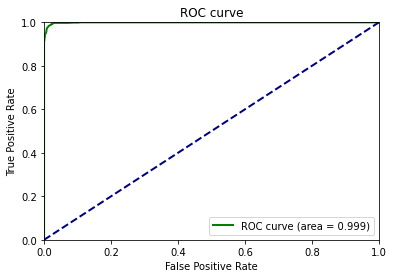

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


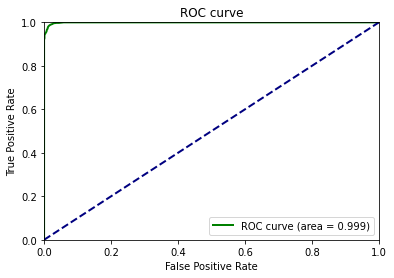

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


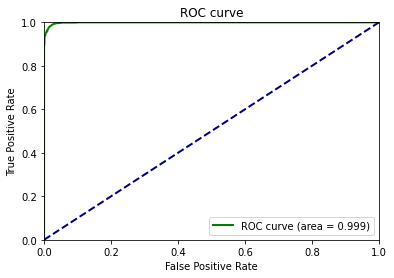

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


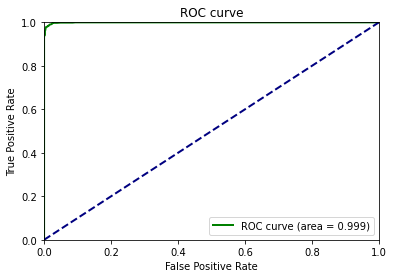

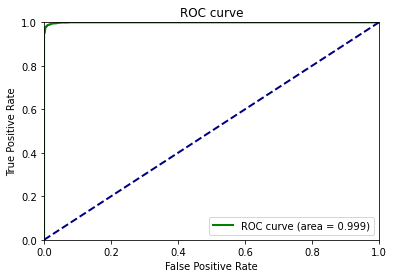

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
scores = perform_kfold(df, clf)

In [17]:
print(scores)
print(f"ROC: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

[0.99911883 0.99921655 0.9989494  0.99939298 0.99945829]
ROC: 0.999 (+/- 0.000)


Strange. Both approaches yield similar results.

Since both approaches yield similar results, we will use the first approach, since this is a lot simpler (thanks to the built in cross validation function of sklearn).